In [32]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import scipy.io as sio

In [33]:
project = 'kolmogorov'

In [34]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = True
latent_dim = 20

In [36]:
L1, L2 = 2*np.pi, 2*np.pi
n1, n2 = 64, 64

grid_x = np.linspace(0,L1-L1/n1,n1)
grid_y = np.linspace(0,L2-L2/n2,n2)

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

Kx = np.concatenate([np.arange(0, n1//2), np.arange(-n1//2, 0)]) * (2 * np.pi / L1)
Ky = np.concatenate([np.arange(0, n2//2), np.arange(-n2//2, 0)]) * (2 * np.pi / L2)

kx, ky = np.meshgrid(Kx,Ky)

dt_sim = 0.5
T_sim = 10000
nt = int(T_sim/dt_sim)

In [37]:
u1 = np.load(f'{project_root}/data/{project}/u1.npy') 
u2 = np.load(f'{project_root}/data/{project}/u2.npy')
w = np.load(f'{project_root}/data/{project}/vorticity.npy')
nt, n1, n2 = u1.shape

X, scaler = transform_data_for_AE(u1,u2)
X_flat = X.reshape(X.shape[0], -1)

data = transform_data_for_AE_inverse(X, scaler)

print(f"Data shape: {X.shape}, Flat shape: {X_flat.shape}")

Data shape: (20000, 2, 64, 64), Flat shape: (20000, 8192)


In [38]:
# === Consistent train/val/test split ===
train_idx, val_idx, test_idx = split_indices(nt, split=(0.3, 0.2, 0.5))

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (6000, 2, 64, 64), Val shape: (4000, 2, 64, 64), Test shape: (10000, 2, 64, 64)


In [39]:
mlp_input_dim = X.reshape(X.shape[0], -1).shape[1]

In [40]:
pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim)
mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'))
mlp.to(device)
cnn = CNN_AE(latent_dim=latent_dim)
cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
cnn.to(device);

In [41]:
# Compute test error for each model

# 1. PCA only (reconstruction from PCA)
X_pca_recon, Z_pca = pca.forward(X)
X_pca_recon = X_pca_recon.reshape(X.shape)
X_pca_recon = transform_data_for_AE_inverse(X_pca_recon, scaler)
pca_test_mse = np.mean((data[test_idx] - X_pca_recon[test_idx]) ** 2)
print(f"PCA test RMSE: {np.sqrt(pca_test_mse):.6f}")

# 2. PCA + MLP Autoencoder
mlp.eval()
with torch.no_grad():
    X_mlp_recon, Z_mlp = mlp(torch.tensor(X, dtype=torch.float32, device=device))
    X_mlp_recon = X_mlp_recon.cpu().numpy()
    X_mlp_recon = X_mlp_recon.reshape(X.shape)
    X_mlp_recon = transform_data_for_AE_inverse(X_mlp_recon, scaler)

    mlp_test_mse = np.mean((data[test_idx] - X_mlp_recon[test_idx]) ** 2)
print(f"MLP AE test RMSE: {np.sqrt(mlp_test_mse):.6f}")

# 3. CNN Autoencoder (batched to avoid CUDA OOM)
cnn.eval()
batch_size = 16  
n_samples = X.shape[0]
X_cnn_recon = []
with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        recon_batch, _ = cnn(batch_tensor)
        X_cnn_recon.append(recon_batch.cpu().numpy())
X_cnn_recon = np.concatenate(X_cnn_recon, axis=0)
X_cnn_recon = transform_data_for_AE_inverse(X_cnn_recon, scaler)
cnn_test_mse = np.mean((data[test_idx] - X_cnn_recon[test_idx]) ** 2)
print(f"CNN AE test RMSE: {np.sqrt(cnn_test_mse):.6f}")


PCA test RMSE: 0.227951
MLP AE test RMSE: 0.177517
CNN AE test RMSE: 0.118724


In [42]:
# Calculate vorticity from predictions of each model

# 1. PCA
u1_pca = X_pca_recon[:, 0].reshape(-1, n1, n2)
u2_pca = X_pca_recon[:, 1].reshape(-1, n1, n2)
w_pca = vort(u1_pca, u2_pca, kx, ky)

# 2. MLP AE
u1_mlp = X_mlp_recon[:, 0].reshape(-1, n1, n2)
u2_mlp = X_mlp_recon[:, 1].reshape(-1, n1, n2)
w_mlp = vort(u1_mlp, u2_mlp, kx, ky)

# 3. CNN AE
u1_cnn = X_cnn_recon[:, 0].reshape(-1, n1, n2)
u2_cnn = X_cnn_recon[:, 1].reshape(-1, n1, n2)
w_cnn = vort(u1_cnn, u2_cnn, kx, ky)

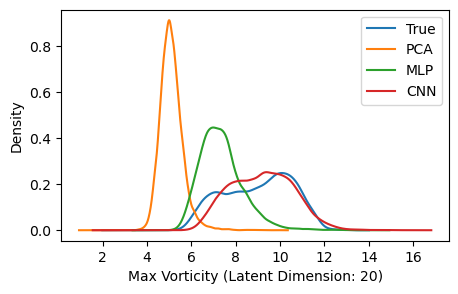

In [43]:
# Compute maximum vorticity for each model and the true data
max_w_true = np.max(np.abs(w), axis=(1,2))
max_w_pca = np.max(np.abs(w_pca), axis=(1,2))
max_w_mlp = np.max(np.abs(w_mlp), axis=(1,2))
max_w_cnn = np.max(np.abs(w_cnn), axis=(1,2))

plt.figure(figsize=(5, 3))
for max_w, label in [
    (max_w_true, 'True'),
    (max_w_pca, 'PCA'),
    (max_w_mlp, 'MLP'),
    (max_w_cnn, 'CNN')
]:
    kde_x, kde_y = custom_KDE(max_w).evaluate()
    plt.plot(kde_x, kde_y, label=label)
plt.xlabel('Max Vorticity (Latent Dimension: {})'.format(latent_dim))
plt.ylabel('Density')
plt.legend()
# plt.title('KDE of Maximum Vorticity')
plt.savefig(f'{project_root}/figures/{project}/rom/kde_max_vorticity_latent_dim_{latent_dim}.png', bbox_inches='tight', dpi=300)
plt.show()


In [44]:
# Compute RMSE of max vorticity for test set
rmse_max_w_pca = np.sqrt(np.mean((max_w_true[test_idx] - max_w_pca[test_idx]) ** 2))
rmse_max_w_mlp = np.sqrt(np.mean((max_w_true[test_idx] - max_w_mlp[test_idx]) ** 2))
rmse_max_w_cnn = np.sqrt(np.mean((max_w_true[test_idx] - max_w_cnn[test_idx]) ** 2))

print(f"PCA max vorticity test RMSE: {rmse_max_w_pca:.6f}")
print(f"MLP AE max vorticity test RMSE: {rmse_max_w_mlp:.6f}")
print(f"CNN AE max vorticity test RMSE: {rmse_max_w_cnn:.6f}")

# Compute RMSE for u1, u2, and vorticity (omega) on the test set

# True fields
u1_true = data[test_idx, 0]
u2_true = data[test_idx, 1]
w_true = w[test_idx]

# PCA
u1_pca_test = u1_pca[test_idx]
u2_pca_test = u2_pca[test_idx]
w_pca_test = w_pca[test_idx]

rmse_u1_pca = np.sqrt(np.mean((u1_true - u1_pca_test) ** 2))
rmse_u2_pca = np.sqrt(np.mean((u2_true - u2_pca_test) ** 2))
rmse_w_pca = np.sqrt(np.mean((w_true - w_pca_test) ** 2))

# MLP AE
u1_mlp_test = u1_mlp[test_idx]
u2_mlp_test = u2_mlp[test_idx]
w_mlp_test = w_mlp[test_idx]

rmse_u1_mlp = np.sqrt(np.mean((u1_true - u1_mlp_test) ** 2))
rmse_u2_mlp = np.sqrt(np.mean((u2_true - u2_mlp_test) ** 2))
rmse_w_mlp = np.sqrt(np.mean((w_true - w_mlp_test) ** 2))

# CNN AE
u1_cnn_test = u1_cnn[test_idx]
u2_cnn_test = u2_cnn[test_idx]
w_cnn_test = w_cnn[test_idx]

rmse_u1_cnn = np.sqrt(np.mean((u1_true - u1_cnn_test) ** 2))
rmse_u2_cnn = np.sqrt(np.mean((u2_true - u2_cnn_test) ** 2))
rmse_w_cnn = np.sqrt(np.mean((w_true - w_cnn_test) ** 2))

print(f"PCA test RMSE: u1={rmse_u1_pca:.6f}, u2={rmse_u2_pca:.6f}, omega={rmse_w_pca:.6f}")
print(f"MLP AE test RMSE: u1={rmse_u1_mlp:.6f}, u2={rmse_u2_mlp:.6f}, omega={rmse_w_mlp:.6f}")
print(f"CNN AE test RMSE: u1={rmse_u1_cnn:.6f}, u2={rmse_u2_cnn:.6f}, omega={rmse_w_cnn:.6f}")


PCA max vorticity test RMSE: 4.123722
MLP AE max vorticity test RMSE: 2.094890
CNN AE max vorticity test RMSE: 0.887992
PCA test RMSE: u1=0.206741, u2=0.247349, omega=1.293613
MLP AE test RMSE: u1=0.166533, u2=0.187860, omega=1.086791
CNN AE test RMSE: u1=0.117518, u2=0.119917, omega=0.713970


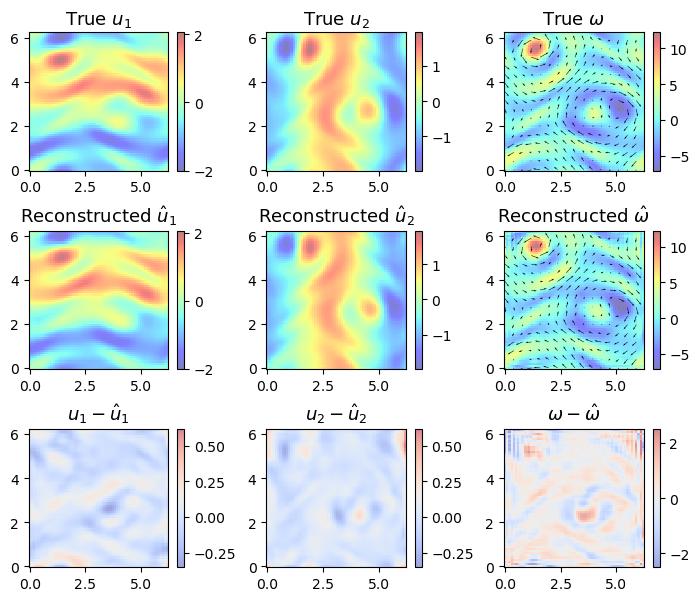

In [47]:
rmse_per_sample = np.sqrt(np.mean((w[test_idx] - w_cnn[test_idx])**2, axis=(1,2)))
avg_rmse = np.mean(rmse_per_sample)

# Find the index in test_idx whose RMSE is closest to the average RMSE
# Find the top 5 indices in test_idx whose RMSEs are closest to the average RMSE
closest_indices = np.argsort(np.abs(rmse_per_sample - avg_rmse))[:5]
idx = test_idx[closest_indices[1]]
fs = 13

fig, axes = plt.subplots(3, 3, figsize=(7, 6))

# First row: u1, u2, w (True)
mesh1 = axes[0, 0].pcolormesh(grid_x, grid_y, u1[idx], cmap='jet', vmin=np.min(u1[idx]), vmax=np.max(u1[idx]), alpha=0.5)
axes[0, 0].set_title('True $u_1$', fontsize=fs)
fig.colorbar(mesh1, ax=axes[0, 0])

mesh2 = axes[0, 1].pcolormesh(grid_x, grid_y, u2[idx], cmap='jet', vmin=np.min(u2[idx]), vmax=np.max(u2[idx]), alpha=0.5)
axes[0, 1].set_title('True $u_2$', fontsize=fs)
fig.colorbar(mesh2, ax=axes[0, 1])

mesh3 = axes[0, 2].pcolormesh(grid_x, grid_y, w[idx], cmap='jet', vmin=np.min(w[idx]), vmax=np.max(w[idx]), alpha=0.5)
axes[0,2].quiver(grid_x[::4, ::4], grid_y[::4, ::4], u1[idx][::4, ::4], u2[idx][::4, ::4], color='black')
axes[0, 2].set_title('True $\omega$', fontsize=fs)
fig.colorbar(mesh3, ax=axes[0, 2])

# Second row: CNN_u1, CNN_u2, CNN_w
mesh4 = axes[1, 0].pcolormesh(grid_x, grid_y, u1_cnn[idx], cmap='jet', vmin=np.min(u1[idx]), vmax=np.max(u1[idx]), alpha=0.5)
axes[1, 0].set_title('Reconstructed $\hat{u}_1$', fontsize=fs)
fig.colorbar(mesh4, ax=axes[1, 0])

mesh5 = axes[1, 1].pcolormesh(grid_x, grid_y, u2_cnn[idx], cmap='jet', vmin=np.min(u2[idx]), vmax=np.max(u2[idx]), alpha=0.5)
axes[1, 1].set_title('Reconstructed $\hat{u}_2$', fontsize=fs)
fig.colorbar(mesh5, ax=axes[1, 1])

mesh6 = axes[1, 2].pcolormesh(grid_x, grid_y, w_cnn[idx], cmap='jet', vmin=np.min(w[idx]), vmax=np.max(w[idx]), alpha=0.5)
axes[1,2].quiver(grid_x[::4, ::4], grid_y[::4, ::4], u1_cnn[idx][::4, ::4], u2_cnn[idx][::4, ::4], color='black')
axes[1, 2].set_title('Reconstructed $\hat{\omega}$', fontsize=fs)
fig.colorbar(mesh6, ax=axes[1, 2])

# Third row: Differences
diff_u1 = u1[idx] - u1_cnn[idx]
diff_u2 = u2[idx] - u2_cnn[idx]
diff_w = w[idx] - w_cnn[idx]

vmin = np.min([diff_u1, diff_u2])
vmax = np.max([diff_u1, diff_u2])

mesh7 = axes[2, 0].pcolormesh(grid_x, grid_y, diff_u1, cmap='coolwarm', vmin=vmin, vmax=vmax, alpha=0.5)
axes[2, 0].set_title('$u_1 - \hat{u}_1$', fontsize=fs)
fig.colorbar(mesh7, ax=axes[2, 0])

mesh8 = axes[2, 1].pcolormesh(grid_x, grid_y, diff_u2, cmap='coolwarm', vmin=vmin, vmax=vmax, alpha=0.5)
axes[2, 1].set_title('$u_2 - \hat{u}_2$', fontsize=fs)
fig.colorbar(mesh8, ax=axes[2, 1])

vmin = -2.5
vmax = 2.5

mesh9 = axes[2, 2].pcolormesh(grid_x, grid_y, diff_w, cmap='coolwarm', vmin=vmin, vmax=vmax, alpha=0.5)
axes[2, 2].set_title('$\omega - \hat{\omega}$', fontsize=fs)
fig.colorbar(mesh9, ax=axes[2, 2])

plt.tight_layout(pad=0.65)
plt.savefig(f'{project_root}/figures/{project}/rom/CNN_autoencoder_error_latent_dim_{latent_dim}.png', dpi=300, bbox_inches='tight')
plt.show()
